<a href="https://colab.research.google.com/github/cbaldassari/manifold/blob/main/manifold-informed-wasserstein-barycenter-generateviz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install community
!pip install python-louvain
!pip install tsia
!pip install easydev
!pip install colormap
!pip install tomaster
!pip install ts2vg
!pip install karateclub
!pip install POT
!pip install XlsxWriter
!pip install umap-learn
!pip install trimap
!pip install pacmap

In [ ]:
%%capture
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime
from sklearn import mixture
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis
from tqdm import tqdm
import xlsxwriter

import os
import sys
import seaborn as sns

import pickle

from matplotlib import gridspec
from numba import njit, prange
from pyts.image import MarkovTransitionField

import tsia.plot
import tsia.markov
import tsia.network_graph

import community
from community import community_louvain
import networkx as nx

from matplotlib.colors import to_hex

from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.stats import kurtosis, skew

import csv
from colormap import rgb2hex
from tomaster import tomato

import seaborn as sns
from pickle import FALSE
import scipy

from ts2vg import NaturalVG
from ts2vg import HorizontalVG
import networkx as nxg
import uuid
from joblib import dump, load


# import libraries
import scipy.linalg as spl
import scipy.stats as sps
%matplotlib inline

# Optimal Transport library https://github.com/rflamary/POT
import ot
import ot.plot

# for interactive widgets
#from ipywidgets import interact, interactive, fixed, interact_manual

#import ipdb

from karateclub import ASNE
from karateclub import Diff2Vec
from karateclub import GraphWave
from karateclub import Role2Vec
from karateclub import NEU
from karateclub import NetLSD
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.preprocessing import StandardScaler
import datetime
#from missingpy import MissForest

# Author: Remi Flamary <remi.flamary@unice.fr>
#
# License: MIT License

# sphinx_gallery_thumbnail_number = 4

import matplotlib.pylab as plt
import seaborn as sns
import pickle
import ot
# necessary for 3d plot even if not used
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib.collections import PolyCollection  # noqa

import ot.lp.cvx as cvx
import umap
import random
from karateclub import FeatherGraph
from karateclub import Graph2Vec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import trimap
import pacmap

import plotly
import plotly.express as px

In [ ]:
def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""
#find_between_r( str(model), ".", " object at" )

#Step2


In [ ]:
ret=pd.read_excel("/data/chartData/paper6_dataset.xlsx")

In [ ]:
ret.drop(columns=ret.columns[0], axis=1,  inplace=True)

##Descriptive table

In [ ]:
import pandas as pd
from scipy.stats import skew, kurtosis

# Assuming ret is your DataFrame with 14 time series
# ret = ...

descrip = pd.DataFrame()

for col in ret.columns:
    # Ensure the data is in a numeric format
    series = pd.to_numeric(ret[col], errors='coerce')

    # Calculate statistics
    descrip.loc[col, "mean"] = series.mean()
    descrip.loc[col, "std"] = series.std()
    descrip.loc[col, "skew"] = skew(series)
    descrip.loc[col, "kurtosis"] = kurtosis(series) + 3

# Now 'descrip' DataFrame contains the desired statistics for each time series


In [ ]:
descrip.to_excel("SL_wass_logret_moms.xlsx")

##analysis

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(ret)
ret = pd.DataFrame(scaler.transform(ret), columns = ret.columns)

In [ ]:
support=[]
for (columnName, columnData) in ret.iteritems():
  support.append(columnData.min())
  support.append(columnData.max())

In [ ]:
min(support), max(support)

(0.0, 1.0)

In [ ]:
n = 100

x = np.arange(n, dtype=np.float64)
distout=[]
weight=[]
a=[]
labelsc=[]
for (columnName, columnData) in ret.iteritems():
  histogram, bins = np.histogram(columnData, bins=n, range=(min(support), max(support)), density=True)
  a.append(histogram)
  labelsc.append(columnName)

A = np.vstack((a)).T
M = ot.utils.dist0(n)
M /= M.max()
reg = 1e-3
#weights= np.array([(1/8),(1/8),(1/8),(1/8),(1/8),(1/8),(1/8),(1/56),(1/56),(1/56),(1/56),(1/56),(1/56),(1/56)])
#5*(1/6)+7*(1/42)
ot.tic()
#bary_wass2 = ot.lp.barycenter(A, M, solver='interior-point', weights,verbose=False)
bary_wass2= ot.bregman.barycenter(A, M, reg, verbose=False)

distout.append(bary_wass2)
ot.toc()

Elapsed time : 0.11344575881958008 s


0.11344575881958008

In [ ]:
ret.columns

Index(['sp15', 'nepool', 'paloverde', 'pjm', 'spx', 'gas', 'oil', '  6 m',
       ' 10 m'],
      dtype='object')

In [ ]:
cols=ret.columns
cols.shape

(9,)

In [ ]:
c=0
dik={}
for i in labelsc:
  dik[i]=A[:, c]
  c+=1

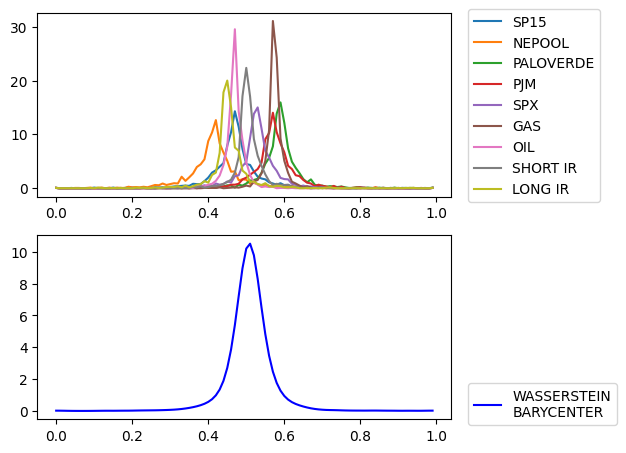

In [ ]:
plt.figure(2)
plt.clf()

plt.subplot(2, 1, 1)
for k, v in dik.items():
    if k=="  6 m":
      k="SHORT IR"
    elif  k=="120 m":
      k="LONG IR"
    plt.plot(bins[:-1], v, label=k.upper())  # Use the label parameter to set the plot names
    #plt.title("Subplot 1")  # Set the title for subplot 1
    plt.legend(loc=(1.04, -0.03))  # Add legend based on the labels

plt.subplot(2, 1, 2)
plt.plot(bins[:-1], bary_wass2, 'b', label="WASSERSTEIN\nBARYCENTER")
#plt.title("Subplot 2")  # Set the title for subplot 2
plt.legend(loc=(1.04, -0.03))
plt.tight_layout()
plt.show()


In [ ]:
sequence=bins
distribution=bary_wass2

In [ ]:
tax_synth=random.choices(sequence[:-1], distribution,k=10000)
tax_synth=pd.DataFrame(tax_synth)

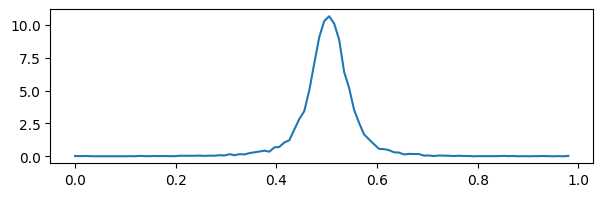

In [ ]:
histogram, bins1 = np.histogram(tax_synth, bins=n,  density=True)
plt.figure(figsize=(7,2))
plt.plot(bins1[:-1], histogram)

##Pick graphs NATURAL

In [ ]:
graphs=[]
map=[]
s=[]

for i in range(5000):
  tax_synth=random.choices(sequence[:-1], distribution,k=1825)
  tax_synth=pd.DataFrame(tax_synth)
  r = tax_synth.values[:,0]

  g = NaturalVG(directed=None,weighted=None).build(r)

  s.append(r)
  graphs.append(g.as_networkx())
  map.append("barycenter")

lst=ret.columns
for i in lst:
  r = ret[i].values
  g = NaturalVG(directed=None,weighted=None).build(r)
  graphs.append(g.as_networkx())
  map.append(str(i))
  s.append(r)

In [ ]:
model = FeatherGraph()
model.fit(graphs)
X = model.get_embedding()

In [ ]:
pickle.dump(X, open("/data/chartData/X_5000_3", "wb"))  # save it into a file named save.p
pickle.dump(map, open("/data/chartData/map_5000_3", "wb"))  # save it into a file named save.p

In [ ]:
#embedding = umap.UMAP(random_state=47,n_jobs=2).fit_transform(X)#, min_dist=0,n_neighbors=10, n_jobs=2
#embedding = TSNE(n_components=2,perplexity=30,verbose=1, random_state=2473).fit_transform(X)
#embedding=PCA(n_components=2).fit_transform(X)
#embedding = trimap.TRIMAP().fit_transform(X2)
embedding = pacmap.PaCMAP(random_state=23).fit_transform(X)

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:819: UserWarning: Warning: random state is set to 23
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [ ]:
myl=map

In [ ]:
for idx, item in enumerate(myl):
    if item=="term1m":
      myl[idx]="1M IR"
    elif item=="  6 m":
      myl[idx]="SHORT IR"
    elif item=="term1Yr":
      myl[idx]="1Y IR"
    elif item=="term5Yr":
      myl[idx]="5Y IR"
    elif item=="term7Yr":
      myl[idx]="7Y IR"
    elif item==" 10 Yr":
      myl[idx]=" LONG IR "
    elif item=="term20Yr":
      myl[idx]="20Y IR"
    elif item=="barycenter":
      myl[idx]="BARYCENTER"
    elif item=="gas":
      myl[idx]="GAS"
    elif item=="oil":
      myl[idx]="OIL"
    elif item=="sp15":
      myl[idx]="SP15"
    elif item=="nepool":
      myl[idx]="NEPOOL"
    elif item=="paloverde":
      myl[idx]="PALOVERDE"
    elif item=="pjm":
      myl[idx]="PJM"
    elif item=="spx":
      myl[idx]="SPX"

In [ ]:
emb=pd.DataFrame()
emb=pd.DataFrame({'dim1': embedding[:,0], 'dim2': embedding[:,1], "legend":myl})
#emb=emb[emb["legend"]!="barycenter"]
fig = px.scatter(emb,
    x="dim1",
    y="dim2",
    color="legend",
    width=900,
    height=700,
    color_discrete_sequence=px.colors.qualitative.T10,
    template='plotly_white'
)

fig.update_xaxes(tickvals=[], showticklabels=False)
fig.update_yaxes(tickvals=[], showticklabels=False)

fig.update_traces(
    marker=dict(size=10, line=dict(width=1, color='white')),
    selector=dict(mode='markers'),
    #showlegend=False
)

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),  # Adjust the margins as needed
    #xaxis=dict(range=[-2, 12]),  # Set your desired x-axis range
    #yaxis=dict(range=[1.5, 9]),  # Set your desired y-axis range
    xaxis_title="",  # Add x-axis label outside the plot
    yaxis_title="",  # Add y-axis label outside the plot
    #legend=dict(x=0, y=1, traceorder='normal'),  # Position the legend to the upper-left

)
fig.update_xaxes(showline=False, showgrid=False, zeroline=False, showticklabels=False)
fig.update_yaxes(showline=False, showgrid=False, zeroline=False, showticklabels=False)
